# Project: Predicting Happiness of Songs

In this demo, we illustrate the classic technique of LASSO regularization for model selection.  You will learn to:
* Fit a LASSO model using the `sklearn` package
* Determine the regularization level with cross-validation
* Draw the coefficient path as a function of the regularization level

We use a classic prostate cancer dataset from the paper:

> Stamey, Thomas A., et al. "[Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate. II. Radical prostatectomy treated patients](http://www.sciencedirect.com/science/article/pii/S002253471741175X)." The Journal of urology 141.5 (1989): 1076-1083.

In the study, the level of [prostate specific antigen](https://en.wikipedia.org/wiki/Prostate-specific_antigen) was measured in 102 men before they had a prostatectomy. Elevated values of the PSA are believed to be associated with the presence of prostate cancer and other disorders. To study this hypothesis, various features of the prostate were measured after the prostatectomy.  Data analysis is then used to understand the relation between the PSA level and prostate features.  The study is old and much more is known about PSA today.  But, the analysis is typical for medical problems and illustrates the basic tools well.

The specific analysis presented in this demo taken from the class text: 

> Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. [Elements of statistical learning](https://www.amazon.com/exec/obidos/ASIN/0387952845/trevorhastie-20), New York: Springer series in statistics, 2001.

The text provides an excellent discussion of LASSO and other methods on this dataset.

First, we load the regular packages.

## Getting the data

In [147]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
playlists = sp.user_playlists('spotify')
data = []
count = 0
while playlists:
    for i, playlist in enumerate(playlists['items']):
        if count < 1100:
            data.append(playlist['id'])
            count += playlist['tracks']['total']
        else:
            break
    if playlists['next'] and count < 1100:
        playlists = sp.next(playlists)
    else:
        playlists = None
print(data, count)
trackIDs = []
for playlistID in data:
    tracks = sp.user_playlist_tracks('spotify',playlistID)
    for i in tracks['items']:
        if 'track' in i and i['track'] != None:
            if 'id' in i['track']:
                ID = i['track']['id']
                trackIDs = trackIDs + [ID]

['37i9dQZF1DXcBWIGoYBM5M', '37i9dQZF1DX0XUsuxWHRQd', '37i9dQZF1DX4dyzvuaRJ0n', '37i9dQZF1DX4SBhb3fqCJd', '37i9dQZF1DXcF6B6QPhFDv', '37i9dQZF1DX1lVhptIYRda', '37i9dQZF1DX10zKzsJ2jva', '37i9dQZF1DX4JAvHpjipBk', '37i9dQZF1DX4E3UdUs7fUx', '37i9dQZF1DX4sWSpwq3LiO', '37i9dQZF1DWYV7OOaGhoH0', '5JdIoXkjfuyWmDdDnznmq1', '37i9dQZF1DX5PuwKY2VZBZ', '37i9dQZF1DXboGLA1CNczK', '37i9dQZF1DWXJfnUiYjUKT', '4HghCZXykAY0kdRqJipQJd', '1LYK2ahDnbLnS4fddCFY7z'] 1115


In [130]:
audio_features = sp.audio_features(trackIDs[1])
feature_labels = list(audio_features[0].keys())[:11]
x = np.array(feature_labels)
print(x)

['danceability' 'energy' 'key' 'loudness' 'mode' 'speechiness'
 'acousticness' 'instrumentalness' 'liveness' 'valence' 'tempo']


In [131]:
for i in range(1, len(trackIDs), 50):
    audio_features = sp.audio_features(trackIDs[i: i+50])
    for tk in audio_features:
        if tk != None:
            features = np.array(list(tk.values())[:11])
            x = np.vstack((x, features))
print(x.shape)

(994, 11)


In [200]:
X = np.column_stack((x[1:,0:9], x[1:,10])).astype(np.float)
y = x[1:,9].astype(np.float)
print ('X\n', X, '\ny\n', y)

X
 [[  5.89000000e-01   7.31000000e-01   2.00000000e+00 ...,   0.00000000e+00
    3.08000000e-01   8.79080000e+01]
 [  6.48000000e-01   6.08000000e-01   8.00000000e+00 ...,   0.00000000e+00
    1.05000000e-01   1.26120000e+02]
 [  6.13000000e-01   8.42000000e-01   1.00000000e+01 ...,   0.00000000e+00
    2.30000000e-01   1.69917000e+02]
 ..., 
 [  5.53000000e-01   4.26000000e-01   1.10000000e+01 ...,   1.47000000e-05
    1.08000000e-01   1.06021000e+02]
 [  4.49000000e-01   1.25000000e-01   1.00000000e+01 ...,   1.08000000e-05
    1.07000000e-01   1.27699000e+02]
 [  2.30000000e-01   9.69000000e-02   0.00000000e+00 ...,   7.60000000e-01
    1.06000000e-01   1.34774000e+02]] 
y
 [ 0.191   0.488   0.645   0.216   0.264   0.434   0.154   0.33    0.333
  0.411   0.356   0.305   0.62    0.405   0.77    0.308   0.13    0.42
  0.819   0.244   0.607   0.182   0.656   0.349   0.579   0.183   0.779
  0.227   0.321   0.141   0.506   0.699   0.261   0.286   0.534   0.649
  0.574   0.332   0.238   

## Visualizing correlation

First, we wanted to see if these features were somehow correlated to happiness. 

Plotting loudness vs. valence.

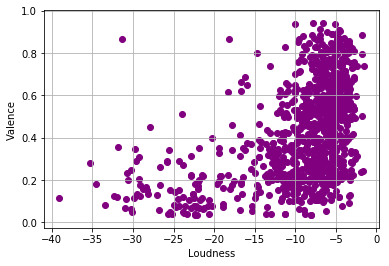

In [201]:
plt.scatter(X[:, 3], y, color='purple')
plt.xlabel('Loudness')
plt.ylabel('Valence')
plt.grid()
plt.show()

Plotting speechiness vs. valence

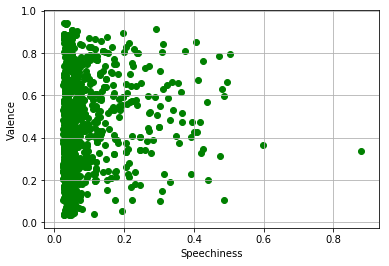

In [202]:
plt.scatter(X[:, 5], y, color='green')
plt.xlabel('Speechiness')
plt.ylabel('Valence')
plt.grid()
plt.show()

## Splitting the data into test and train

In [208]:
ns_train = 700
nsamples = X.shape[0]
ns_test = nsamples - ns_train
X_tr = X[:ns_train,:]     # Gets the first ns_train rows of X
y_tr = y[:ns_train]       # Gets the correspoinding rows of y
X_ts = X[ns_train:, :]
y_ts = y[ns_train:]
print("num samples train = %d, test = %d" % (ns_train, ns_test))

num samples train = 700, test = 293


## Fitting a linear model

In [221]:
import  sklearn.model_selection 
from sklearn import datasets, linear_model, preprocessing

In [222]:
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [223]:
yts_hat = regr.predict(X_ts)
RSS = np.mean(((yts_hat-y_ts)**2)/(np.std(y_ts)**2))
print(RSS)
print(regr.score(X_ts, y_ts))

0.701296726346
0.298703273654
